# Jupyter notebook covid data analysis Tim Hensen

## Importing data

In [65]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn import preprocessing
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [66]:
# importing main dataset
df = pd.read_csv("owid_main_agi.csv")

# Raw data inspection
df.head()

# We only need to use the total cases and deaths, so:
df_total = df.loc[df['date'] == '2020-09-11']

In [67]:
# Import extra datasets
dfa = pd.read_csv('asthma_agi.csv')
dfp = pd.read_csv('air_pollution_agi.csv')
dfs = pd.read_csv('smoking.csv')
dfo = pd.read_csv('obesity.csv')

# Select only latest year of measurement
df_at = dfa.loc[dfa['Year'] == 2017]
df_pt = dfp.loc[dfp['Year'] == 2016]
df_st = dfs.loc[dfs['Year'] == 2012]
df_ot = dfo.loc[dfo['Year'] == 2016]

In [68]:
# Merge new data with main dataset using left join (all extra datasets have more countries than main dataset)
df_ta = df_total.merge(df_at, on='location', how='left')
df_tp = df_ta.merge(df_pt, on='location', how='left')
df_ts = df_tp.merge(df_st, on='location', how='left')
df_to = df_ts.merge(df_ot, on='location', how='left')

df_to = df_to.drop(['Code_x', 
                    'Code_y', 
                    'Year_x', 
                    'Year_y',
                    ' mean annual exposure (micrograms per cubic meter)'], axis=1)

## Data overview

In [69]:
df_to.shape

(211, 21)

In [70]:
df_to.head()

,location,date,total_cases_per_million,total_deaths_per_million,population_density,median_age,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Prevalence - Asthma - Sex: Both - Age: Age-standardized (Percent),PM2.5 air pollution,Daily smoking prevalence,Prevalence of obesity (both sexes) - WHO (2019)
0,Afghanistan,2020-09-11,990.846,36.477,54.422,18.6,1.337,1803.987,NaN,597.029,...,NaN,NaN,37.746,0.50,64.83,0.498,6.215770,62.854857,11.9,5.5
1,Albania,2020-09-11,3773.716,112.586,104.871,38.0,8.643,11803.431,1.1,304.195,...,7.1,51.2,NaN,2.89,78.57,0.785,2.870007,14.634008,20.5,21.7
2,Algeria,2020-09-11,1082.939,36.282,17.348,29.1,3.857,13913.839,0.5,278.364,...,0.7,30.4,83.741,1.90,76.88,0.754,6.127563,37.230956,11.2,27.4
3,Andorra,2020-09-11,16838.154,685.951,163.755,NaN,NaN,NaN,NaN,109.135,...,29.0,37.8,NaN,NaN,83.73,0.858,6.588128,10.879472,26.6,25.6
4,Angola,2020-09-11,94.078,3.834,23.890,16.8,1.362,5819.495,NaN,276.045,...,NaN,NaN,26.664,NaN,61.15,0.581,5.196785,36.240479,8.7,8.2


In [71]:
df_to.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 0 to 210
Data columns (total 21 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   location                                                           211 non-null    object 
 1   date                                                               211 non-null    object 
 2   total_cases_per_million                                            209 non-null    float64
 3   total_deaths_per_million                                           210 non-null    float64
 4   population_density                                                 199 non-null    float64
 5   median_age                                                         186 non-null    float64
 6   aged_70_older                                                      185 non-null    float64
 7   gdp_per_capita            

## Preprocessing

### Case fatality rate

In [72]:
#add mortality rate (cfr)
df_new = df_to
case = df_new['total_cases_per_million']
death = df_new['total_deaths_per_million']
df_new['CFR'] = [death / case for (case, death) in zip(case, death)]

                  location       CFR
206                  Yemen  0.289565
96                   Italy  0.125669
197         United Kingdom  0.116179
18                 Belgium  0.108472
124                 Mexico  0.106764
..                     ...       ...
158  Saint Kitts and Nevis  0.000000
159            Saint Lucia  0.000000
188                  Timor  0.000000
170               Slovakia       NaN
210          International       NaN

[211 rows x 2 columns]


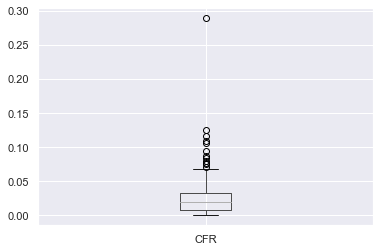

In [73]:
# Explore mortality rates per country
df_new_cfr = df_new.iloc[:,[0,21]]
df_new_cfr = df_new_cfr.sort_values('CFR', axis=0, ascending=False)
print(df_new_cfr)
df_new.boxplot(column = 'CFR')

### Data cleaning: missing values

In [74]:
# Remove non number columns for visualization and further data exploration
df_values = df_new.iloc[:, 2:]

In [75]:
# Are there missing values?
missing = df_values.isnull().sum(axis = 0)
perc_miss = (missing/210) *100
print(perc_miss.sort_values(ascending = False))

handwashing_facilities                                               56.666667
extreme_poverty                                                      42.380952
male_smokers                                                         34.285714
female_smokers                                                       33.333333
hospital_beds_per_thousand                                           21.904762
Prevalence of obesity (both sexes) - WHO (2019)                      16.666667
human_development_index                                              15.238095
Daily smoking prevalence                                             15.238095
gdp_per_capita                                                       13.333333
PM2.5 air pollution                                                  12.857143
aged_70_older                                                        12.380952
Prevalence - Asthma - Sex: Both - Age: Age-standardized (Percent)    11.904762
cardiovasc_death_rate                               

The variables: handwashing_facilities, extreme_poverty, male_smokers and female_smokers have a missing value rate of over 30%, meaning that no meaningfull data analysis can be done with these variables. 

In [76]:
# Remove variables with over 30 percent missing values
df_values1 = df_values.drop(df_values[['extreme_poverty', 
                                       'handwashing_facilities', 
                                       'male_smokers', 
                                       'female_smokers']], axis=1)
missing1 = df_values1.isnull().sum(axis = 0)
perc_miss1 = (missing1/211) *100
print(perc_miss1.sort_values(ascending = False))

hospital_beds_per_thousand                                           21.800948
Prevalence of obesity (both sexes) - WHO (2019)                      16.587678
Daily smoking prevalence                                             15.165877
human_development_index                                              15.165877
gdp_per_capita                                                       13.270142
PM2.5 air pollution                                                  12.796209
aged_70_older                                                        12.322275
Prevalence - Asthma - Sex: Both - Age: Age-standardized (Percent)    11.848341
cardiovasc_death_rate                                                11.848341
median_age                                                           11.848341
diabetes_prevalence                                                   8.530806
population_density                                                    5.687204
life_expectancy                                     

If a country misses data, algorithmic imputing techniques like knn don't portray reality because their is no connection between the alphabetic order of the countries and the variable values. So, we can delete these countries or impute the missing values with zero. 

In [77]:
# Removing rows with  any missing values
df_values2 = df_values1.dropna()
df_values2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 0 to 208
Data columns (total 16 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   total_cases_per_million                                            153 non-null    float64
 1   total_deaths_per_million                                           153 non-null    float64
 2   population_density                                                 153 non-null    float64
 3   median_age                                                         153 non-null    float64
 4   aged_70_older                                                      153 non-null    float64
 5   gdp_per_capita                                                     153 non-null    float64
 6   cardiovasc_death_rate                                              153 non-null    float64
 7   diabetes_prevalence       

### Checking data for strange values

In [78]:
# Are there any negative values?
# Only select columns with numbers
df_values2 = df_values2.iloc[:, 2:17]
# Find for each column the number of negative values
df_values2.to_numpy()
np.sum(np.array(df_values2) < 0, axis=0)  

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [79]:
# Are there any strange values for each variable?
# display minimum higher than zero
a = np.array(df_values2.min(axis=0))
b = np.array(df_values2.max(axis=0))
c = df_values2.columns
table = zip(c,a,b)
print(tabulate(table, headers= ['column', 'min', 'max'], tablefmt="presto"))

 column                                                            |       min |           max
-------------------------------------------------------------------+-----------+---------------
 population_density                                                |   1.98    |   7915.73
 median_age                                                        |  15.1     |     48.2
 aged_70_older                                                     |   0.526   |     18.493
 gdp_per_capita                                                    | 661.24    | 116936
 cardiovasc_death_rate                                             |  79.37    |    724.417
 diabetes_prevalence                                               |   0.99    |     22.02
 hospital_beds_per_thousand                                        |   0.1     |     13.05
 life_expectancy                                                   |  53.28    |     84.63
 human_development_index                                           |   0.354   |   

## Outlier detection and data visualization

### Boxplot

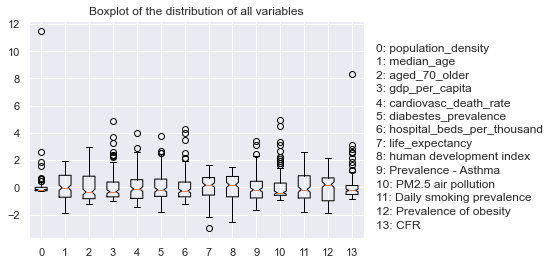

In [80]:
df_scaled = StandardScaler().fit_transform(df_values2)
feat_cols = [str(i) for i in range(df_scaled.shape[1])]
df_norm = pd.DataFrame(df_scaled,columns=feat_cols)# df_scaled = pd.DataFrame(data=df_scaled)
df_norm = df_norm.T
plt.text(15, 10, '0: population_density')
plt.text(15, 9, '1: median_age')
plt.text(15, 8, '2: aged_70_older')
plt.text(15, 7, '3: gdp_per_capita')
plt.text(15, 6, '4: cardiovasc_death_rate')
plt.text(15, 5, '5: diabestes_prevalence')
plt.text(15, 4, '6: hospital_beds_per_thousand')
plt.text(15, 3, '7: life_expectancy')
plt.text(15, 2, '8: human development index')
plt.text(15, 1, '9: Prevalence - Asthma')
plt.text(15, 0, '10: PM2.5 air pollution')
plt.text(15, -1, '11: Daily smoking prevalence')
plt.text(15, -2, '12: Prevalence of obesity')
plt.text(15, -3, '13: CFR')

plt.title('Boxplot of the distribution of all variables')
plt.boxplot(df_norm, notch='True', labels=feat_cols)
plt.show()

### PCA

In [81]:
# Label countries with high, medium and low mortality rate
# ultra = df_new_cfr.iloc[0:35,1]
# very_high = df_new_cfr.iloc[35:70,1]
# high = df_new_cfr.iloc[70:105,1]
# medium = df_new_cfr.iloc[105:140,1]
# medium_low = df_new_cfr.iloc[140:175,1]
# low = df_new_cfr.iloc[175:210,1]

# df_new['CFR'].replace(ultra, 'extremely high',inplace=True)
# df_new['CFR'].replace(very_high, 'very high',inplace=True)
# df_new['CFR'].replace(high, 'high',inplace=True)
# df_new['CFR'].replace(medium, 'medium',inplace=True)
# df_new['CFR'].replace(medium_low, 'low',inplace=True)
# df_new['CFR'].replace(low, 'very low',inplace=True)
# print(df_new['CFR'])

In [82]:

very_high = df_new_cfr.iloc[0:10,1]
high = df_new_cfr.iloc[10:70,1]
medium = df_new_cfr.iloc[70:140,1]
low = df_new_cfr.iloc[140:210,1]

df_new['CFR'].replace(very_high, 'very high',inplace=True)
df_new['CFR'].replace(high, 'high',inplace=True)
df_new['CFR'].replace(medium, 'medium',inplace=True)
df_new['CFR'].replace(low, 'low',inplace=True)


In [83]:
# visualization
df_scaled = StandardScaler().fit_transform(df_values2)

feat_cols = ['feature'+str(i) for i in range(df_scaled.shape[1])]

df_norm = pd.DataFrame(df_scaled,columns=feat_cols)# df_scaled = pd.DataFrame(data=df_scaled)

df_norm.head()
# df_scaled.boxplot()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13
0,-0.226745,-1.454936,-1.054626,-0.916802,2.914831,0.477158,-1.036854,-1.307591,-1.552462,0.700820,0.807696,-0.667112,-1.492640,0.287246
1,-0.151484,0.759700,0.643576,-0.416896,0.437340,0.607768,-0.016689,0.726917,0.385622,-1.307489,-0.616472,0.448812,0.323410,0.064663
2,-0.282053,-0.256293,-0.468879,-0.311390,0.218800,-0.285173,-0.439268,0.476675,0.176282,0.647874,0.050912,-0.757943,0.962391,0.181667
3,0.037939,0.086177,-0.288971,0.067415,-0.516011,1.431405,0.371742,0.497405,0.351857,1.497611,-0.585404,-1.770060,0.009525,0.120309
4,-0.283800,0.063346,0.364184,-0.060419,-0.520064,-0.613029,0.883959,0.445580,0.655738,-0.136480,-0.630821,0.293102,1.063282,-0.219856


In [84]:
df_norm.mean()

feature0     3.229080e-17
feature1    -2.742904e-16
feature2    -8.344814e-17
feature3    -1.886654e-17
feature4     2.046293e-16
feature5    -1.422246e-16
feature6     8.635068e-17
feature7     6.051804e-16
feature8     4.789197e-17
feature9     3.352438e-16
feature10    1.378708e-16
feature11   -1.364196e-16
feature12    1.237209e-16
feature13   -2.993248e-18
dtype: float64

In [85]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pc_df = pca.fit_transform(df_norm)


pc_DF = pd.DataFrame(data = pc_df
             , columns = ['pc1', 'pc2', 'pc3'])
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
pca.explained_variance_ratio_[0] = round(pca.explained_variance_ratio_[0]*100,1)
pca.explained_variance_ratio_[1] = round(pca.explained_variance_ratio_[1],3)*100
pca.explained_variance_ratio_[2] = round(pca.explained_variance_ratio_[2],3)*100

print(pca.explained_variance_ratio_) 

Explained variation per principal component: [0.40333118 0.1376238  0.09296927]
[40.3 13.8  9.3]


In [86]:
print(pc_DF)

          pc1       pc2       pc3
0    3.715547  0.044797  0.766423
1   -0.910084 -0.842195  0.634151
2    0.148637  0.796458 -0.462848
3   -0.548272  1.897233 -0.620729
4   -1.261345 -0.552603 -0.207019
..        ...       ...       ...
148  0.407153  0.374113 -0.129436
149  0.673892 -1.149514 -0.424641
150  3.002307 -1.062107 -3.099085
151  2.936094 -0.650078 -0.829365
152  3.155106 -1.182356 -0.765519

[153 rows x 3 columns]


### PCA plots (pc1 v pc2, pc1 v pc3, pc2 v pc3)

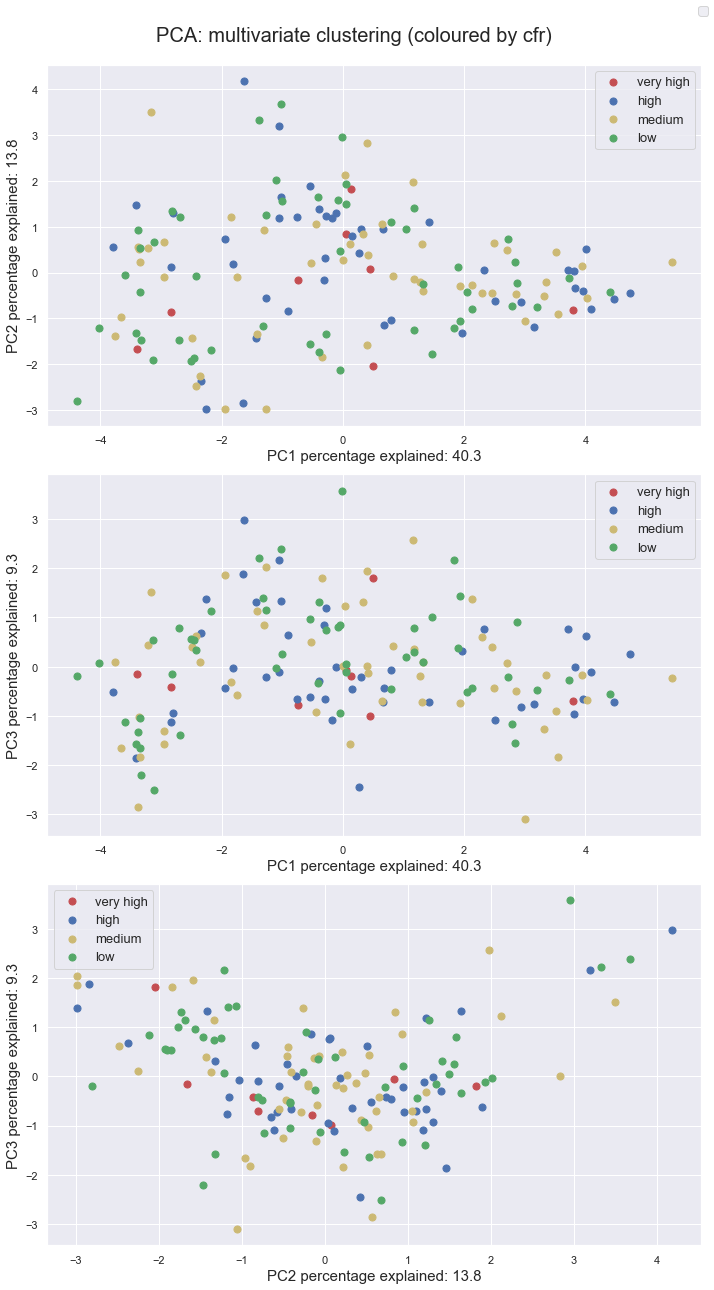

In [87]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,18))

ax[0].set_xlabel('PC1 percentage explained: {}' .format(pca.explained_variance_ratio_[0]) ,fontsize=15)
ax[0].set_ylabel('PC2 percentage explained: {}' .format(pca.explained_variance_ratio_[1]),fontsize=15)

ax[1].set_xlabel('PC1 percentage explained: {}' .format(pca.explained_variance_ratio_[0]) ,fontsize=15)
ax[1].set_ylabel('PC3 percentage explained: {}' .format(pca.explained_variance_ratio_[2]),fontsize=15)

ax[2].set_xlabel('PC2 percentage explained: {}' .format(pca.explained_variance_ratio_[1]) ,fontsize=15)
ax[2].set_ylabel('PC3 percentage explained: {}' .format(pca.explained_variance_ratio_[2]),fontsize=15)

fig.suptitle("PCA: multivariate clustering (coloured by cfr)", fontsize=20)
fig.legend(targets,prop={'size': 13})
targets = ['very high','high', 'medium', 'low']
colors = ['r', 'b', 'y', 'g']

for target, color in zip(targets,colors):
    indicesToKeep = df_new['CFR'] == target
    ax[0].scatter(pc_DF.loc[indicesToKeep, 'pc1']
               , pc_DF.loc[indicesToKeep, 'pc2']
                ,c = color, s = 50)
    ax[0].legend(targets,prop={'size': 13})
    
    ax[1].scatter(pc_DF.loc[indicesToKeep, 'pc1']
               , pc_DF.loc[indicesToKeep, 'pc3']
            ,c = color, s = 50)
    ax[1].legend(targets,prop={'size': 13})
    
    ax[2].scatter(pc_DF.loc[indicesToKeep, 'pc2']
               , pc_DF.loc[indicesToKeep, 'pc3']
            ,c = color, s = 50)
    ax[2].legend(targets,prop={'size': 13})




fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.legend(targets,prop={'size': 13})

##outlier detection using isolation forest 

In [88]:
df_values3 = df_values2.reset_index()
df_values3.head()

,index,population_density,median_age,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,Prevalence - Asthma - Sex: Both - Age: Age-standardized (Percent),PM2.5 air pollution,Daily smoking prevalence,Prevalence of obesity (both sexes) - WHO (2019),CFR
0,0,54.422,18.6,1.337,1803.987,597.029,9.59,0.50,64.83,0.498,6.215770,62.854857,11.900000,5.5,0.036814
1,1,104.871,38.0,8.643,11803.431,304.195,10.08,2.89,78.57,0.785,2.870007,14.634008,20.500000,21.7,0.029834
2,2,17.348,29.1,3.857,13913.839,278.364,6.73,1.90,76.88,0.754,6.127563,37.230956,11.200000,27.4,0.033503
3,6,231.845,32.1,4.631,21490.943,191.511,13.17,3.80,77.02,0.780,7.543192,15.685943,3.400000,18.9,0.031579
4,7,16.177,31.9,7.441,18933.907,191.032,5.50,5.00,76.67,0.825,4.820861,14.148167,19.299999,28.3,0.020912


# Isolation forest

In [89]:
to_model_columns=df_values3.columns

#Make trees for isolation forest and specify the metrics
clf=IsolationForest(n_estimators=500, max_samples='auto', contamination='auto', \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)

#n_estimaters: number of trees (default)
#contamination: proportion of outliers in the datast
#n_jobs: number of jobs to run in parallel. -1 means all processors
#random_state: integer seed to make results reproducible

clf.fit(df_values3[to_model_columns]) #fit isolation trees

pred = clf.predict(df_values3[to_model_columns]) #predict outliers. -1 is outlier. 1 is inlier.

df_values3['anomaly']=pred

outliers=df_values3.loc[df_values3['anomaly']==-1]

outlier_index=list(outliers.index)

print(df_values3['anomaly'].value_counts())

 1    139
-1     14
Name: anomaly, dtype: int64


In [90]:
print(pc_DF)

          pc1       pc2       pc3
0    3.715547  0.044797  0.766423
1   -0.910084 -0.842195  0.634151
2    0.148637  0.796458 -0.462848
3   -0.548272  1.897233 -0.620729
4   -1.261345 -0.552603 -0.207019
..        ...       ...       ...
148  0.407153  0.374113 -0.129436
149  0.673892 -1.149514 -0.424641
150  3.002307 -1.062107 -3.099085
151  2.936094 -0.650078 -0.829365
152  3.155106 -1.182356 -0.765519

[153 rows x 3 columns]


## 3D pca with outliers

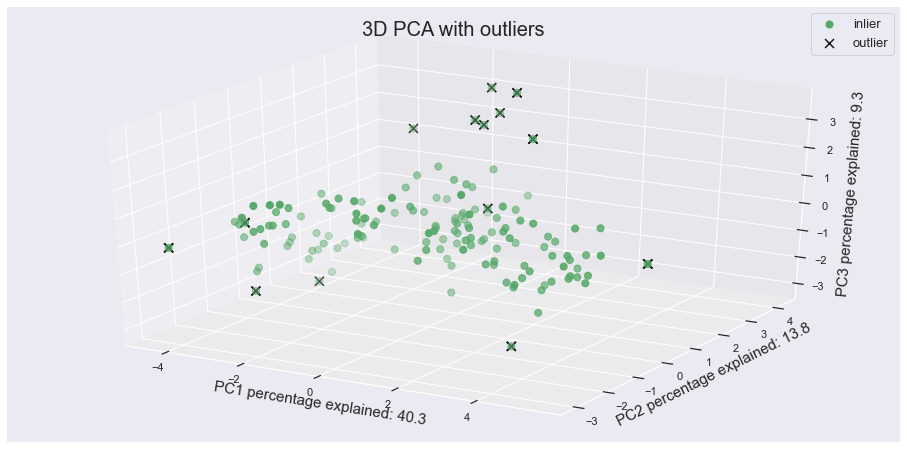

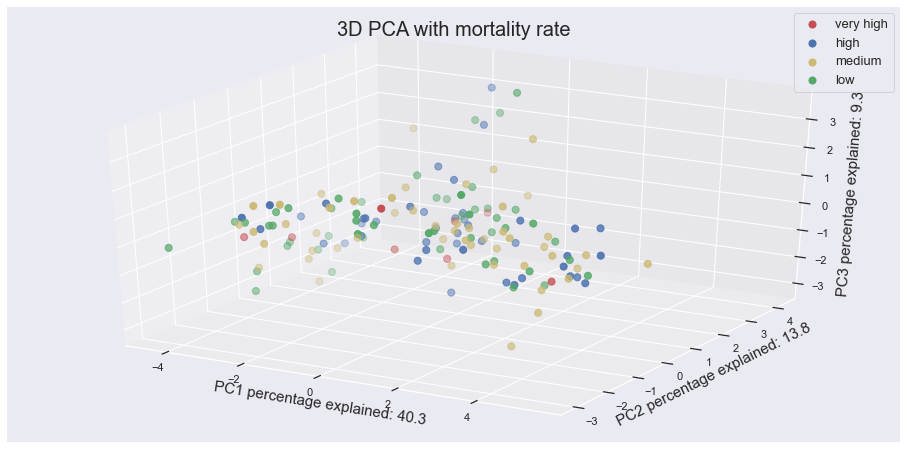

In [91]:
ax[0] = plt.figure(figsize=(16,8)).gca(projection='3d')
ax[1] = plt.figure(figsize=(16,8)).gca(projection='3d')

ax[0].set_xlabel('PC1 percentage explained: {}' .format(pca.explained_variance_ratio_[0]) ,fontsize=15)
ax[0].set_ylabel('PC2 percentage explained: {}' .format(pca.explained_variance_ratio_[1]),fontsize=15)
ax[0].set_zlabel('PC3 percentage explained: {}' .format(pca.explained_variance_ratio_[2]),fontsize=15)

ax[1].set_xlabel('PC1 percentage explained: {}' .format(pca.explained_variance_ratio_[0]) ,fontsize=15)
ax[1].set_ylabel('PC2 percentage explained: {}' .format(pca.explained_variance_ratio_[1]),fontsize=15)
ax[1].set_zlabel('PC3 percentage explained: {}' .format(pca.explained_variance_ratio_[2]),fontsize=15)

ax[0].set_title('3D PCA with outliers',fontsize=20)
ax[1].set_title('3D PCA with mortality rate',fontsize=20)

targets = ['very high','high', 'medium', 'low']
colors = ['r', 'b', 'y', 'g']

for target, color in zip(targets,colors):
    indicesToKeep = df_new['CFR'] == target
    ax[0].scatter(pc_DF.loc[indicesToKeep, 'pc1']
               , pc_DF.loc[indicesToKeep, 'pc2']
                ,pc_DF.loc[indicesToKeep, 'pc3'],
                c = 'g', s = 50)
    ax[0].scatter(pc_DF.iloc[outlier_index,0]
           , pc_DF.iloc[outlier_index,1]
            ,pc_DF.iloc[outlier_index,2],
            c = 'k', s = 80, marker = 'x', label='outliers')
    ax[0].legend(['inlier', 'outlier'],prop={'size': 13})
    
    ax[1].scatter(pc_DF.loc[indicesToKeep, 'pc1']
               , pc_DF.loc[indicesToKeep, 'pc2']
                ,pc_DF.loc[indicesToKeep, 'pc3'],
                c = color, s = 50)
    ax[1].legend(targets,prop={'size': 13})

# Remove outliers 

In [92]:
df_values4 = df_values3.drop(index=outlier_index, axis=0)

## Linear regression

##Ordinal linear regression

R-squared: 0.19710068448856877
intercept: -1.6434452345136578e-16
slope: [-0.08822023 -0.16816819  0.50949506  0.05033307 -0.15401787 -0.0090811
 -0.1382705   0.15163633 -0.03842424 -0.16474028 -0.01775629 -0.10153555]


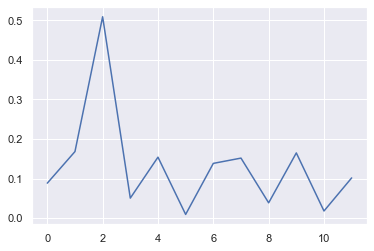

In [210]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

#First make sure all features have the same scale
df4_scaled = StandardScaler().fit_transform(df_values4)
df_norm1 = pd.DataFrame(df4_scaled)#Transform numpy into a dataframe

#split data in dependent (y) and independent (x) features
x = df_norm1.iloc[:,1:13] 
y = df_norm1.iloc[:,14] #CFR

model = LinearRegression(normalize=True).fit(x,y)

r_sq = model.score(x, y)
print('R-squared:', r_sq)

print('intercept:', model.intercept_)

print('slope:', model.coef_)
plt.figure()
plt.plot(abs(model.coef_))
plt.show()

In [96]:
df_values5 = df_values4.drop(df_values4[['index', 'CFR', 'anomaly']], axis=1)
col = pd.DataFrame(df_values5.columns)
coefs = pd.DataFrame(model.coef_)
df5 = pd.concat([col, coefs], axis=1)
print(tabulate(df5, headers= ['feature', 'coefficient'], tablefmt='presto'))

# The coefficient value represents the mean change in the response given a one unit change in the predictor. 
# For example, if a coefficient is +3, the mean response value increases by 
# 3 for every one unit change in the predictor.

    | feature                                                           |   coefficient
----+-------------------------------------------------------------------+---------------
  0 | population_density                                                |    -0.0753489
  1 | median_age                                                        |    -0.124039
  2 | aged_70_older                                                     |     0.478556
  3 | gdp_per_capita                                                    |     0.0720167
  4 | cardiovasc_death_rate                                             |    -0.161621
  5 | diabetes_prevalence                                               |    -0.0223571
  6 | hospital_beds_per_thousand                                        |    -0.137972
  7 | life_expectancy                                                   |     0.149265
  8 | human_development_index                                           |    -0.13081
  9 | Prevalence - Asthma - Sex: Both 

##Partial least square regression

R-squared: 0.17384021992069754
slope: 
 [[-0.07774126]
 [ 0.0602826 ]
 [ 0.132941  ]
 [ 0.06814082]
 [-0.20706485]
 [-0.1196194 ]
 [-0.07862345]
 [ 0.07237497]
 [ 0.0413516 ]
 [-0.06545106]
 [-0.01620352]
 [-0.05856035]]


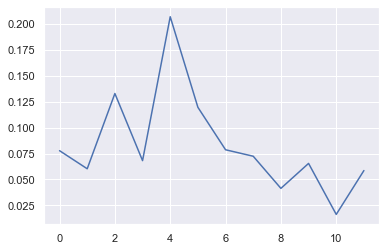

In [211]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
x1 = df_norm1.iloc[:,1:13] 
y1 = df_norm1.iloc[:,14]

pls2 = PLSRegression(n_components=2)
pls2.fit(x1, y1)

score = pls2.score(x1,y1)
print('R-squared:', score)
#print('intercept:', pls2.intercept_)
print('slope: \n', pls2.coef_)
plt.figure()
plt.plot(abs(pls2.coef_))
plt.show()

[0.05596129 0.09409791 0.07497489 0.04395961 0.20270651 0.09816929
 0.0547296  0.08488694 0.06886652 0.07463404 0.07215742 0.07485598]
0.8714031307588815


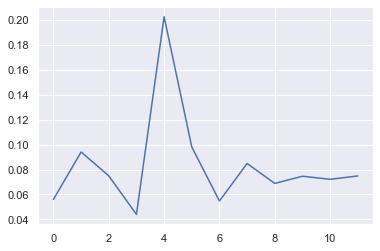

In [206]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

x2 = df_norm1.iloc[:,1:13] 
y2 = df_norm1.iloc[:,14]

reg = RandomForestRegressor(random_state=1)
reg1 = reg.fit(x2, y2)
importances = reg1.feature_importances_
print(importances)
pred =reg1.predict(x2)
r_sq = reg.score(x2, y2)

print(r_sq)
# print('slope: \n', reg.coef_)
plt.figure()
plt.plot(importances)
plt.show()

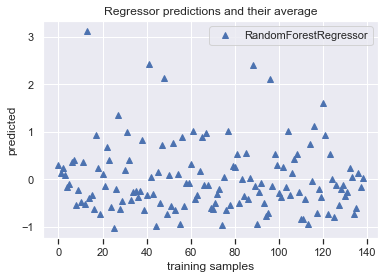

In [197]:
plt.figure()
plt.plot(pred, 'b^', label='RandomForestRegressor')

plt.tick_params(axis='x', which='both', bottom=True, top=False,
                labelbottom=True)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

plt.show()

In [194]:
print(reg1)

RandomForestRegressor(random_state=1)


Todo
Find multivariate outliers x
    Robust PCA
    isolation forest x 
    Why samples are outliers
Remove outliers x 
(mutual dependance) 
Linear regression x
canonical correlations

split data according to human development index
HCA: ward's method